# Analyse des sessions

On va s'intéresser dans cette section à l'historique des activités (sessions) des utilisateurs. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

users['found_destination'] = users.apply(lambda r: 'DF' if r['country_destination'] != 'NDF' else 'NDF', axis=1)

On a vu, dans l'introduction, qu'on ne dispose pas des sessions de tous les utilisateurs. De ce fait, on va sélectioner les utilisateurs qui ont une session avant d'équilibrer les classes (DF/NDF).

In [17]:
base_user_ids = sessions['user_id'].unique()
base_user_ids = base_user_ids.tolist()
base_user_ids.remove(np.nan)

test_user_ids = test_users['id'].values
base_user_ids = list(set(base_user_ids) - set(test_user_ids))

users_by_ids = users.set_index('id')
session_users = users_by_ids.loc[base_user_ids]

session_users_ndf = session_users[session_users['found_destination'] == 'NDF'].head(20000)
session_users_df = session_users[session_users['found_destination'] == 'DF'].head(20000)
session_users = pd.concat([session_users_ndf, session_users_df])

sessions = sessions[sessions['user_id'].isin(session_users.index)]
print(f'sessions.shape : {sessions.shape}')
sessions.head()

sessions.shape : (4296798, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


On a 28000 utilisateurs DF et NDF.

In [21]:
sessions['found_destination'] = sessions.apply(lambda r: session_users.loc[r['user_id'], 'found_destination'], axis=1)

Median NDF : 189.74444444444444 h
Median DF : 329.62958333333336 h


Text(0.5, 1.0, 'Temps médian passé sur le site en secondes')

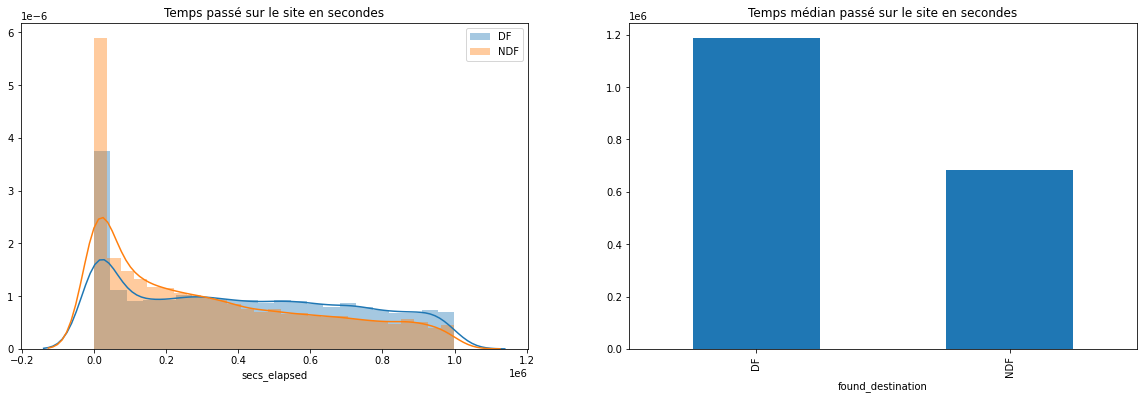

In [39]:
time_elapsed = sessions.groupby(['user_id', 'found_destination'])['secs_elapsed'].sum()
# sns.distplot(time_elapsed)
f = plt.figure(figsize=(20, 6))
f.add_subplot(1, 2, 1)
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'DF'], label='DF')
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'NDF'], label='NDF')
plt.title("Temps passé sur le site en secondes")
plt.legend()
print(f'Median NDF : {time_elapsed.loc[:, "NDF"].median() / (60**2)} h')
print(f'Median DF : {time_elapsed.loc[:, "DF"].median() / (60**2)} h')

f.add_subplot(1, 2, 2)
time_elapsed.groupby('found_destination').median().plot(kind='bar')
_ = plt.title("Temps médian passé sur le site en secondes")

Les DF passent beaucoup plus de temps sur le site que les NDF, probablement car ils font l'effort de renseigner leur profil, passer du temps sur les différentes annonces, écrire aux hôtes pour poser des questions, etc. Il est possible qu'une partie des NDF ne font que regarder, mais ce ne sont que des hypothèses.

On va récupérer les actions les plus présentes chez les DF puis chez les NDF.

In [73]:
# Actions that are common among DF / NDF
actions = sessions.groupby(['user_id', 'found_destination']).agg({'action': pd.Series.tolist}).reset_index()
actions['number_actions'] = actions.apply(lambda r: r['action'].__len__(), axis=1)
actions.head()

,user_id,found_destination,action,number_actions
0,00023iyk9l,DF,"[index, dashboard, header_userpic, dashboard, ...",40
1,0028jgx1x1,NDF,"[show, reviews, show, search, show, search, re...",31
2,002qnbzfs5,DF,"[social_connections, payment_methods, create, ...",789
3,0035hobuyj,DF,"[lookup, search_results, lookup, search_result...",489
4,00389675gq,NDF,"[similar_listings, edit, create, verify, phone...",177


In [ ]:
def count_actions(action, booked):
    actions['tmp'] = actions.apply(lambda r: 1 if action in r['action'] else 0, axis=1)
    res = actions[actions['found_destination'] == booked]['tmp'].sum()
    actions.drop('tmp', axis=1)
    return res

# Actions that are the most common among DF
action_stats_df = pd.DataFrame()
action_stats_df['action'] = sessions.action.unique()
action_stats_df['count'] = action_stats_df.apply(lambda r: count_actions(r['action'], 'DF'), axis=1)

# Actions that are the most common among NDF
action_stats_ndf = pd.DataFrame()
action_stats_ndf['action'] = sessions.action.unique()
action_stats_ndf['count'] = action_stats_ndf.apply(lambda r: count_actions(r['action'], 'NDF'), axis=1)

# Combine DF and NDF
action_stats = pd.DataFrame()
action_stats['action'] = filtered_sessions['action'].unique()
action_stats['count_df'] = action_stats_df['count'].values
action_stats['count_ndf'] = action_stats_ndf['count'].values
action_stats['diff'] = (action_stats['count_df'] - action_stats['count_ndf']) / (action_stats['count_df'] + action_stats['count_ndf'])

In [ ]:
action_stats[action_stats['count_df'] + action_stats['count_ndf'] > 500].sort_values(by='diff').head()

In [ ]:
action_stats[action_stats['count_df'] + action_stats['count_ndf'] > 500].sort_values(by='diff').tail(10).sort_values(by='diff', ascending=False)